In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
from rpy2.robjects.packages import importr

utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages('lme4')

%load_ext rpy2.ipython

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/lme4_1.1-27.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3311365 bytes (3.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

In [44]:
# Load data
utterances = pd.read_csv("results/intelligibility/conversations.csv")

# convert True/False to 0/1:
utterances.replace({False: 0, True: 1}, inplace=True)

utterances.head()


,speaker_code,transcript_raw,tokens,pos,start_time,end_time,age,corpus,transcript_file,child_name,...,is_speech_related,is_intelligible,response_is_speech_related,response_is_intelligible,response_latency,response_latency_follow_up,follow_up_speech_related,follow_up_intelligible,has_response,caregiver_response_contingent
0,CHI,&ma .,.,None,565381.0,567217.0,10,Edinburgh,/home/mitja/data/CHILDES/Edinburgh/clarice0901...,Edinburgh_Clarice,...,1.0,0,1.0,1,0.0,922.0,1.0,0,1,0
1,CHI,&Ua .,.,None,280928.0,283571.0,10,Edinburgh,/home/mitja/data/CHILDES/Edinburgh/clarice0904...,Edinburgh_Clarice,...,1.0,0,1.0,1,0.0,3086.0,1.0,0,1,0
2,CHI,&rare .,.,None,286657.0,288715.0,10,Edinburgh,/home/mitja/data/CHILDES/Edinburgh/clarice0904...,Edinburgh_Clarice,...,1.0,0,1.0,1,0.0,2269.0,1.0,0,1,0
3,CHI,&=babble .,.,None,402463.0,409476.0,10,Edinburgh,/home/mitja/data/CHILDES/Edinburgh/clarice0904...,Edinburgh_Clarice,...,1.0,0,1.0,1,0.0,4452.0,1.0,0,1,0
4,CHI,&=babbles &=squeals .,.,None,1239572.0,1245124.0,10,Edinburgh,/home/mitja/data/CHILDES/Edinburgh/clarice0904...,Edinburgh_Clarice,...,1.0,0,1.0,1,0.0,6436.0,1.0,0,1,0


In [45]:
# Some children have very few data points:
counts = utterances.groupby("child_name").size()
counts

child_name
Bernstein_Alice       3
Bernstein_Gail        3
Bernstein_Marie       1
Bloom_Peter        1560
Braunwald_Laura    8003
                   ... 
Weist_Benjamin      985
Weist_Emily        4812
Weist_Emma         1392
Weist_Jillian      1220
Weist_Matt          164
Length: 345, dtype: int64

In [46]:
# Exclude children with less than 100 datapoints:
# child_names_enough_data = [name for name, count in counts.items() if count > 100]
# print(len(utterances))
# utterances = utterances[utterances.child_name.isin(child_names_enough_data)]
# print(len(utterances))

## Caregiver Contingency
### By child

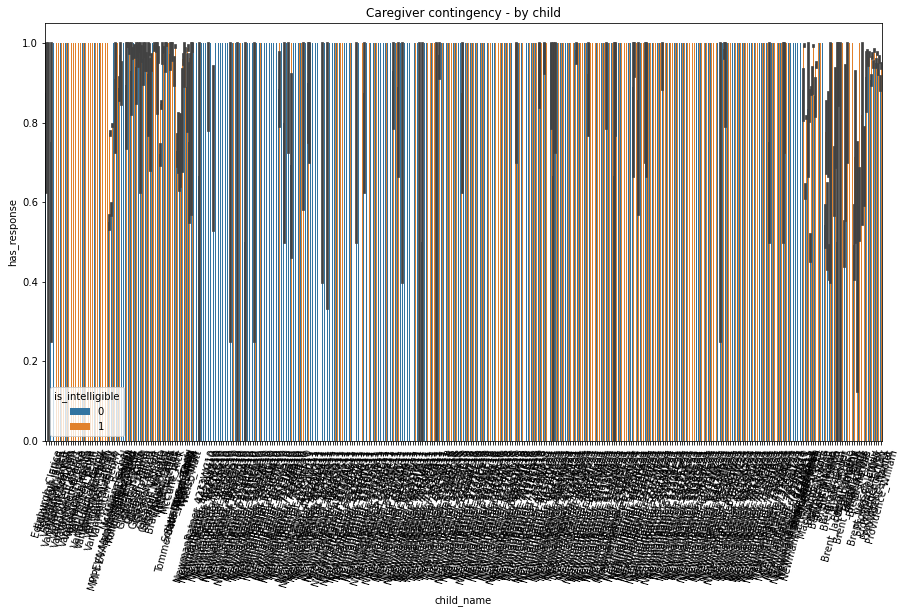

In [55]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.figure()
sns.barplot(
        data=utterances,
        x="child_name",
        y="has_response",
        hue="is_intelligible"
)
plt.title("Caregiver contingency - by child")
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.3)

### By Age

Text(0.5, 1.0, 'Caregiver contingency - by age')

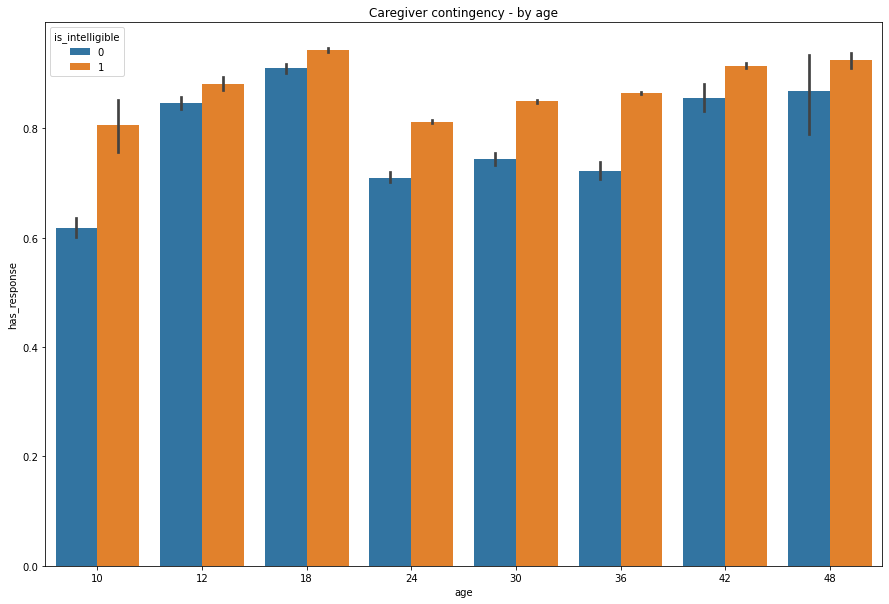

In [48]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances,
        x="age",
        y="has_response",
        hue="is_intelligible"
)
plt.title("Caregiver contingency - by age")

## Child contingency
### By Child


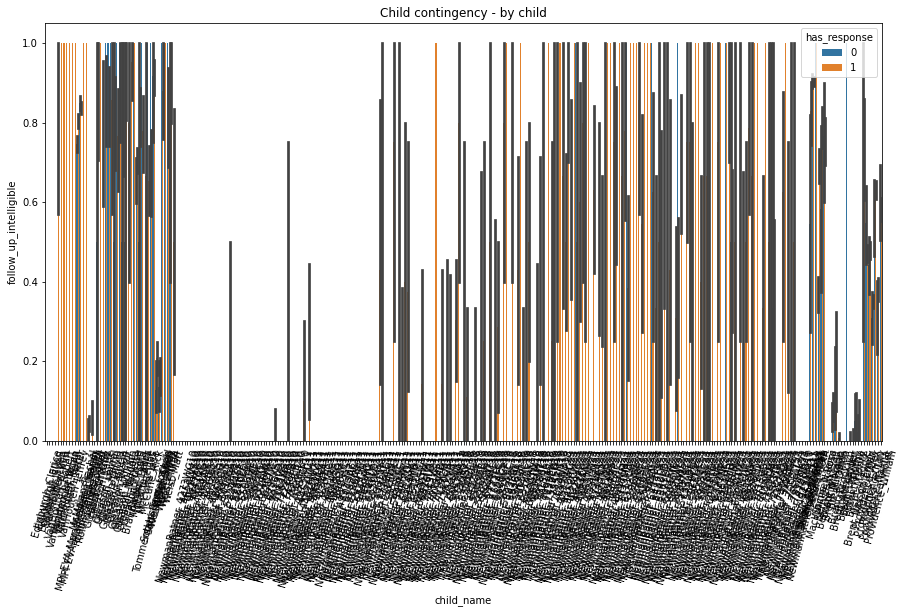

In [57]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.figure()
sns.barplot(
        data=utterances[utterances["is_intelligible"] == 1],
        x="child_name",
        y="follow_up_intelligible",
        hue="has_response"
)
plt.title("Child contingency - by child")
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.3)

### By Age

Text(0.5, 1.0, 'Child contingency - by age')

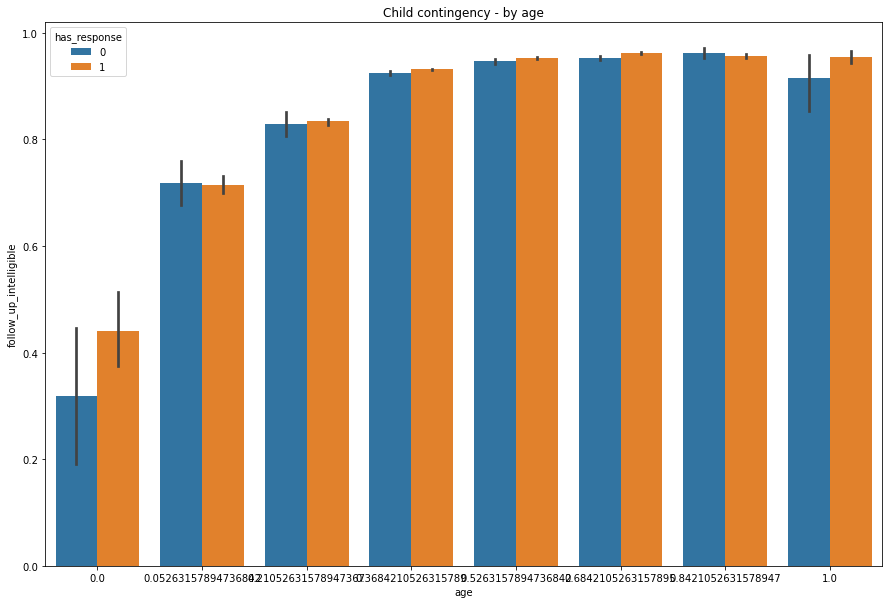

In [58]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances[utterances["is_intelligible"] == 1],
        x="age",
        y="follow_up_intelligible",
        hue="has_response"
)
plt.title("Child contingency - by age")

## Caregiver contingency
### GLM (with mixed effects)

In [51]:
# normalize age
min_age, max_age = utterances["age"].min(), utterances["age"].max()
utterances["age"] = (utterances["age"] - min_age) / (max_age - min_age) * (1 - 0)


In [52]:
%%R -i utterances
library(lme4)

# Caregiver contingency
m_caregiver_contingency<-glmer('has_response ~ is_intelligible * age + (1 | child_name)', data=utterances, family=binomial) #, control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
print(summary(m_caregiver_contingency))


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: has_response ~ is_intelligible * age + (1 | child_name)
   Data: utterances

      AIC       BIC    logLik  deviance  df.resid 
 281091.2  281145.1 -140540.6  281081.2    356037 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-15.8079   0.1232   0.4492   0.5022   1.0981 

Random effects:
 Groups     Name        Variance Std.Dev.
 child_name (Intercept) 2.121    1.457   
Number of obs: 356042, groups:  child_name, 345

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          2.96336    0.06888  43.022   <2e-16 ***
is_intelligible      0.94671    0.02907  32.566   <2e-16 ***
age                  0.73394    0.05490  13.370   <2e-16 ***
is_intelligible:age  0.09436    0.05612   1.681   0.0927 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         

## Child Contingency
### GLM (with mixed effects)

In [53]:
print(len(utterances[utterances["is_intelligible"] == 0]))

31077


In [54]:
%%R -i utterances
library(lme4)

utterances_child_intelligible = subset(utterances, is_intelligible==1)

# Child contingency
m_child_contingency<-glmer('follow_up_intelligible ~ has_response * age + (1 | child_name)', data=utterances_child_intelligible, family=binomial)
print(summary(m_child_contingency))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: follow_up_intelligible ~ has_response * age + (1 | child_name)
   Data: utterances_child_intelligible

     AIC      BIC   logLik deviance df.resid 
136199.9 136253.3 -68094.9 136189.9   324960 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-14.4050   0.1631   0.1984   0.2542   2.2456 

Random effects:
 Groups     Name        Variance Std.Dev.
 child_name (Intercept) 1.955    1.398   
Number of obs: 324965, groups:  child_name, 250

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.53208    0.09415   5.651 1.59e-08 ***
has_response      0.50450    0.04630  10.897  < 2e-16 ***
age               1.85385    0.08812  21.037  < 2e-16 ***
has_response:age -0.25869    0.09228  -2.803  0.00506 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        